In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets,transforms 

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

In [4]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
    ])

In [5]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [6]:
train_dir = 'datasets/Spill_Data/Train'
test_dir = 'datasets/Spill_Data/Test'
batch_size = 8
num_workers = 4

In [7]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform)

In [8]:
train_data

Dataset ImageFolder
    Number of datapoints: 300
    Root location: datasets/Spill_Data/Train

In [9]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           shuffle=True, 
                                           num_workers=num_workers)

In [10]:
test_data = datasets.ImageFolder(root=test_dir,
                                transform=test_transform)

In [11]:
test_data

Dataset ImageFolder
    Number of datapoints: 113
    Root location: datasets/Spill_Data/Test

In [12]:
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)

In [13]:
dataloaders = {
    'train': train_loader,
    'test': test_loader
}

In [14]:
total_batch_sizes = { 'train': len(train_loader), 'test': len(test_loader) }

In [15]:
total_batch_sizes

{'train': 38, 'test': 15}

In [16]:
class_names = train_data.classes

print(class_names)

['NoSpill', 'OilSpill']


In [17]:
def imshow(inp, title):

    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure (figsize = (12, 6))

    plt.imshow(inp)
    plt.title(title)
    plt.pause(5) 

In [18]:
inputs, classes = next(iter(dataloaders['train']))

In [19]:
out = torchvision.utils.make_grid(inputs)

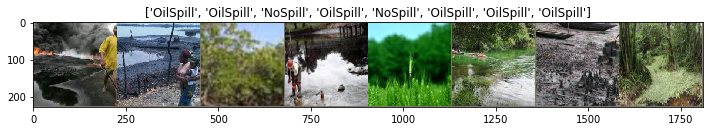

In [20]:
imshow(out, title=[class_names[x] for x in classes])

In [21]:
from torchvision import models

In [22]:
model = models.resnet18(pretrained=True) 

In [23]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [24]:
num_ftrs = model.fc.in_features
num_ftrs

512

In [25]:
count = 0 
for child in model.children():
    count+=1
    
count

10

In [26]:
count = 0 
for child in model.children():
    count+=1
    if count < 7:
        for param in child.parameters():
            param.requires_grad = False

In [27]:
model.fc = nn.Linear(num_ftrs, 2)

In [28]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [29]:
criterion        = nn.CrossEntropyLoss()

optimizer_ft     = optim.Adam(model.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR( optimizer_ft, step_size=7, gamma=0.1)

In [30]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    model = model.to(device)
    
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            
            if phase == 'train':
                
                scheduler.step()
                model.train()  
                
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / total_batch_sizes[phase]
            epoch_acc = running_corrects.double() / (total_batch_sizes[phase] * batch_size)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Training complete')
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    
    return model

In [31]:
model = train_model(model, criterion, optimizer_ft,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 3.9528 Acc: 0.7829
test Loss: 1.9814 Acc: 0.8500
Epoch 1/4
----------
train Loss: 2.3193 Acc: 0.8750
test Loss: 1.7249 Acc: 0.8583
Epoch 2/4
----------
train Loss: 2.1361 Acc: 0.8750
test Loss: 2.1872 Acc: 0.8417
Epoch 3/4
----------
train Loss: 1.6051 Acc: 0.9211
test Loss: 0.2497 Acc: 0.9333
Epoch 4/4
----------
train Loss: 1.9285 Acc: 0.9112
test Loss: 0.8453 Acc: 0.9000
Training complete
Best val Acc: 0.933333


In [32]:
model.eval() 

with torch.no_grad():
    
    correct = 0
    total = 0
    
    for images, labels in dataloaders['test']:
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {}%'\
          .format(100 * correct / total))

Accuracy of the model on the test images: 99.11504424778761%


Acutal label 0


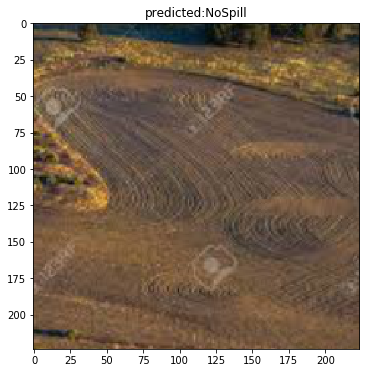

Acutal label 1


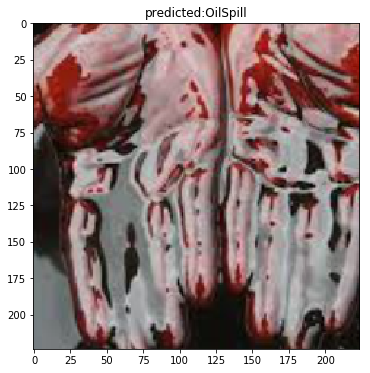

Acutal label 1


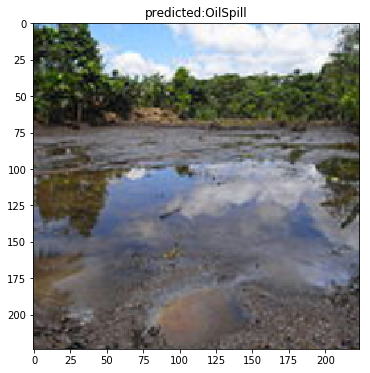

Acutal label 0


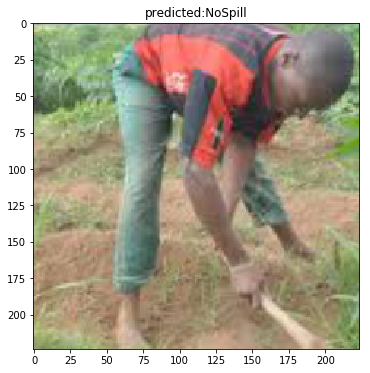

Acutal label 1


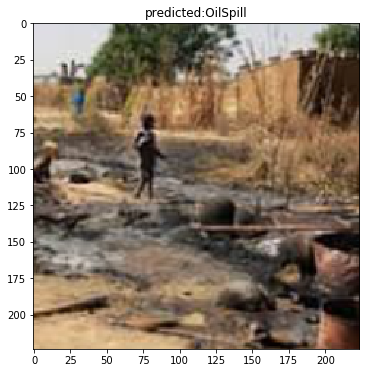

Acutal label 0


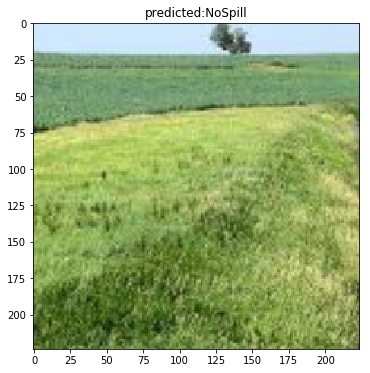

Acutal label 1


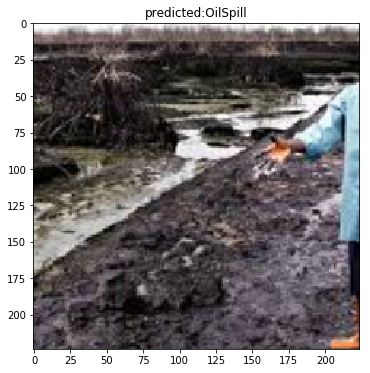

Acutal label 0


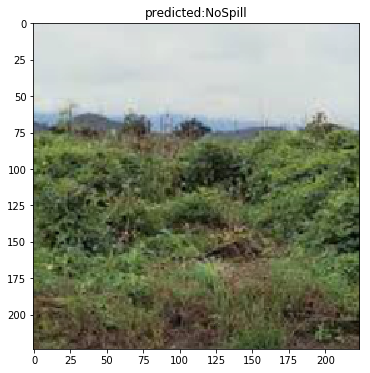

In [33]:
with torch.no_grad():
    
    inputs, labels = iter(dataloaders['test']).next()
    
    inputs = inputs.to(device)
        
    inp = torchvision.utils.make_grid(inputs)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    for j in range(len(inputs)):
        print ("Acutal label", np.array(labels)[j])
        inp = inputs.data[j]
        imshow(inp, 'predicted:' + class_names[preds[j]])